In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from astropy import utils, io
from astropy.io import fits
from astropy.table import Table, vstack, join

from sklearn.cluster import DBSCAN

from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from skimage.feature import canny
from skimage import data
from skimage.draw import line

from scipy import misc

from PIL import Image
import PIL.ImageOps    

%matplotlib inline

In [21]:
file='/net/dl1/dlusers/katiefasbender/dat_m.fits' 
hdul=fits.open(file)
dat_m=hdul[1].data
Xx=np.column_stack((dat_m['ra'],dat_m['dec']))

## Obtain outliers from DBSCAN on all measurements

In [22]:
#Compute DBSCAN -----------------------------------------------------------------------------------------
db_1 = DBSCAN(eps=0.000138889, min_samples=2).fit(Xx)

#Get outliers -------------------------------------------------------------------------------------------
outliers=db_1.labels_==-1 #define outliers from DBSCAN labels
X_out=np.column_stack((np.array(dat_m['ra'][outliers]),np.array(dat_m['dec'][outliers]))) #coordinates of DBSCAN outliers

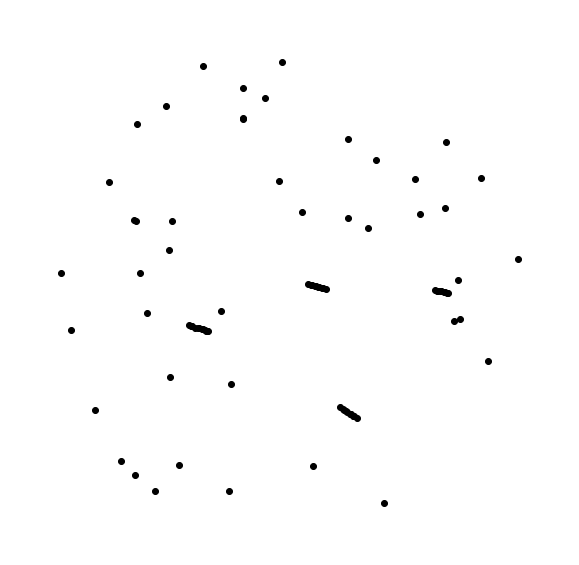

In [48]:
plt.figure(figsize=(10,10))
plt.scatter(dat_m[outliers]['ra'],dat_m[outliers]['dec'],c="Black")
plt.ticklabel_format(useOffset=False)
plt.tick_params(left=False,bottom=False,labelleft=False, labelbottom=False)
plt.box(False)
plt.show()

The following is an attempt to use the Hough Transform to identify fast - moving tracklets.  

# I. Straight-line Hough Transform

This is what the transform should do:

Example 1 (simulating two crossed tracklets)

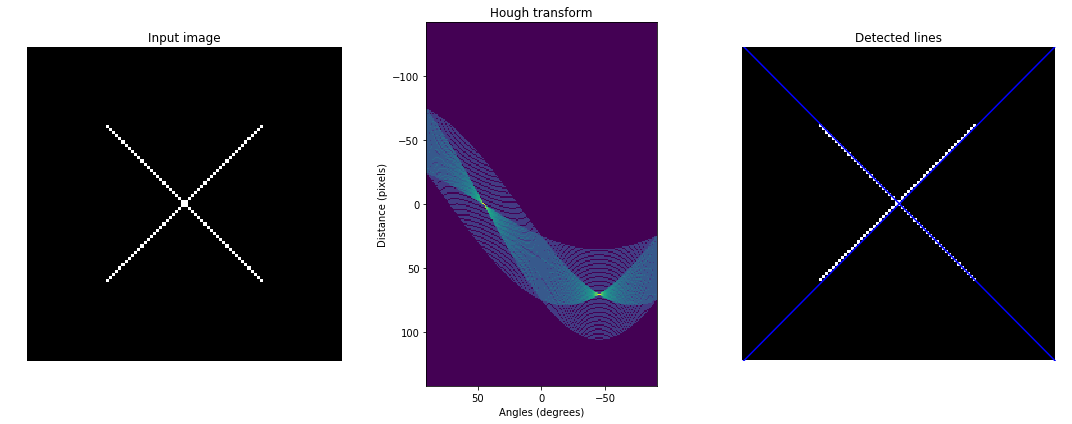

In [5]:
# Construct test image
image = np.zeros((100, 100))
idx = np.arange(25, 75)
image[idx[::-1], idx] = 255
image[idx, idx] = 255

# Straight-line Hough transform
h, theta, d = hough_line(image)

#Plot -----------------------------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()
#Input Image ----------------------------------------------------------------------------------------
ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()
#Hough Transform ------------------------------------------------------------------------------------
ax[1].imshow(np.log(1 + h),extent=[np.rad2deg(theta[-1]),np.rad2deg(theta[0]),d[-1],d[0]],aspect=1/1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')
#Detected Lines -------------------------------------------------------------------------------------
ax[2].imshow(image, cmap=cm.gray)
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - image.shape[1] * np.cos(angle)) / np.sin(angle)
    ax[2].plot((0, image.shape[1]), (y0, y1), '-r',color='blue')
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.tight_layout()
plt.show()

Example 2 (simulating one tracklet with a noisy background)

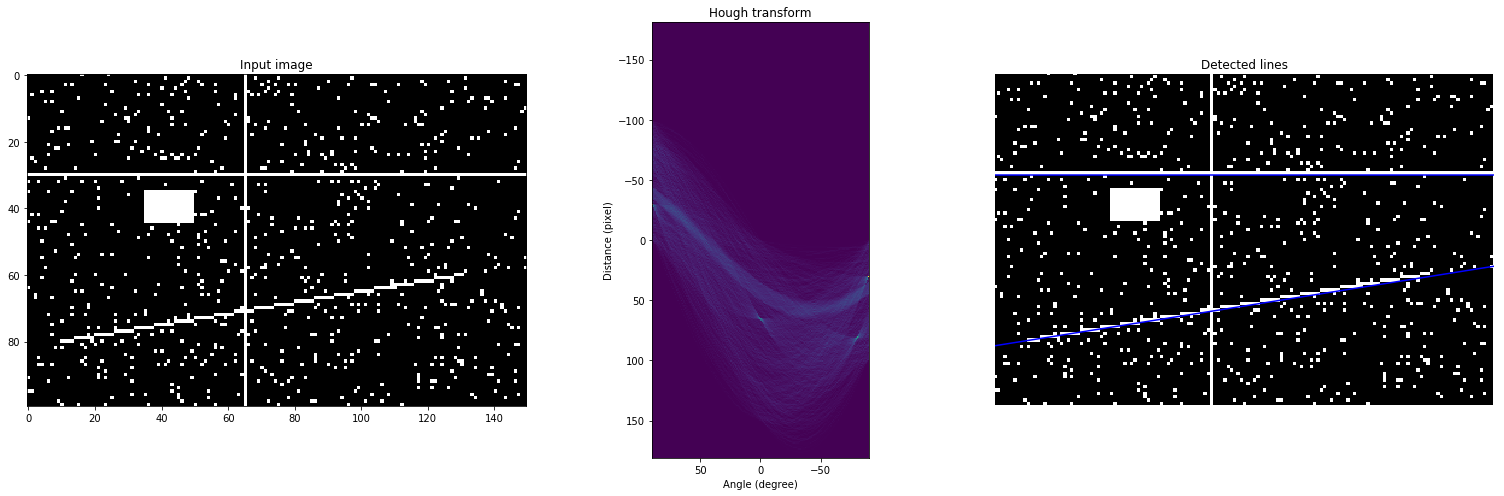

In [23]:
img = np.zeros((100, 150), dtype=bool)
img[30, :] = 1
img[:, 65] = 1
img[35:45, 35:50] = 1
rr, cc = line(60, 130, 80, 10)
img[rr, cc] = 1
img += np.random.random(img.shape) > 0.95

# Straight-line Hough transform
out, angles, d = hough_line(img)

#Plot -----------------------------------------------------------------------------------------------
fix, axes = plt.subplots(1, 3, figsize=(21, 7))
#Input Image ----------------------------------------------------------------------------------------
axes[0].imshow(img, cmap=plt.cm.gray)
axes[0].set_title('Input image')
#Hough Transform ------------------------------------------------------------------------------------
axes[1].imshow(out, extent=(np.rad2deg(angles[-1]), np.rad2deg(angles[0]), d[-1], d[0]))
axes[1].set_title('Hough transform')
axes[1].set_xlabel('Angle (degree)')
axes[1].set_ylabel('Distance (pixel)')
#Detected Lines -------------------------------------------------------------------------------------
axes[2].imshow(img, cmap=cm.gray)
for _, angle, dist in zip(*hough_line_peaks(out, angles, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - img.shape[1] * np.cos(angle)) / np.sin(angle)
    axes[2].plot((0, img.shape[1]), (y0, y1), '-r',color='blue')
axes[2].set_xlim((0, img.shape[1]))
axes[2].set_ylim((img.shape[0], 0))
axes[2].set_axis_off()
axes[2].set_title('Detected lines')

plt.tight_layout()
plt.show()

This is what the tansform actually does on an image of the DBSCAN outliers:

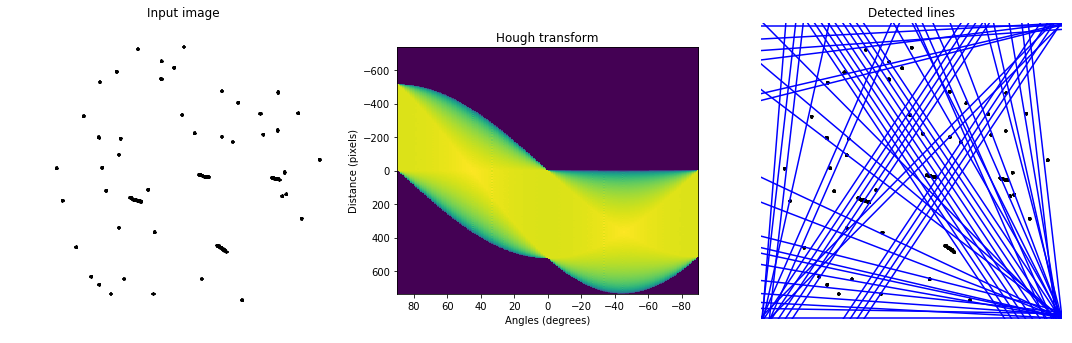

In [6]:
# Construct image
im = Image.open("outliers.png") # open colour image
im = im.convert('L') # convert image to monochrome
image=np.array(im)

# Straight-line Hough transform
h, theta, d = hough_line(image)

#Plot -----------------------------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()
#Input Image ----------------------------------------------------------------------------------------
ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()
#Hough Transform ------------------------------------------------------------------------------------
ax[1].imshow(np.log(1 + h),extent=[np.rad2deg(theta[-1]),np.rad2deg(theta[0]),d[-1],d[0]],aspect=.1/1)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
#Detected Lines -------------------------------------------------------------------------------------
ax[2].imshow(image, cmap=cm.gray)
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - image.shape[1] * np.cos(angle)) / np.sin(angle)
    ax[2].plot((0, image.shape[1]), (y0, y1), '-r',color='blue')
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.tight_layout()
plt.show()

The straight line Hough Transform function from skimage doesn't have many parameters - you put in the image array, and you can choose the range of $\theta$ of the detected lines. Luckily, there's also.....................

# II. Probabilistic Hough Transform

This function has more adjustable parameters than the straight-line version.  On example image:

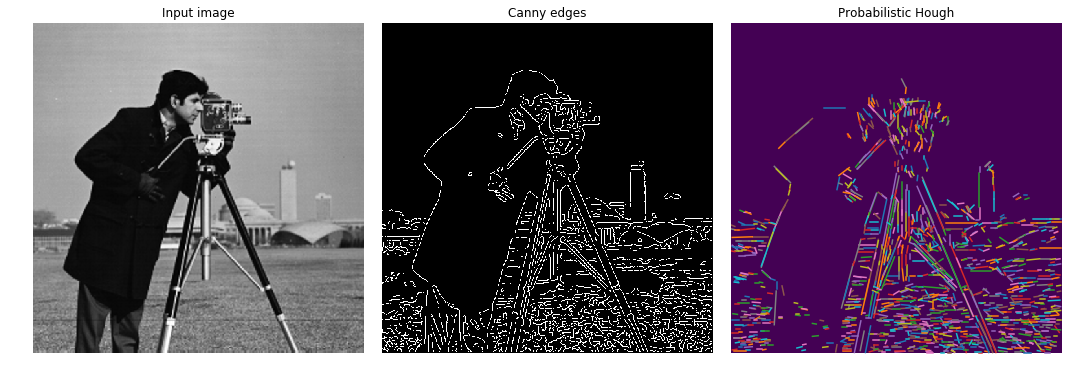

In [14]:
#Construct image
image = data.camera()

#Get Canny Edges
edges = canny(image, 2, 1, 25)

#Probabilistic Hough Transform
lines = probabilistic_hough_line(edges, threshold=10, line_length=5, line_gap=3)

#Plot ------------------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()
#Input Image -----------------------------------------------------------------------------
ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
#Canny Edges -----------------------------------------------------------------------------
ax[1].imshow(edges, cmap=cm.gray)
ax[1].set_title('Canny edges')
#Probabilistic Hough Lines ---------------------------------------------------------------
ax[2].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

After finding the canny edges of an image, the probabilistic hough transform finds multiple lines (line length can be set).  

Trying to figure out how to read image of DBSCAN outliers in a 2D numpy array:

In [7]:
#face = misc.imread('outliers.png')
#type(face) 

#testy=plt.imread('outliers.png')
#testy.shape

image_file = Image.open("outliers.png") # open colour image
image_file= image_file.convert('L') # convert image to monochrome - this works
image_array=np.array(image_file) #turn into array
image_array.shape

(516, 525)

## Testing different parameters

#### line_length = 5

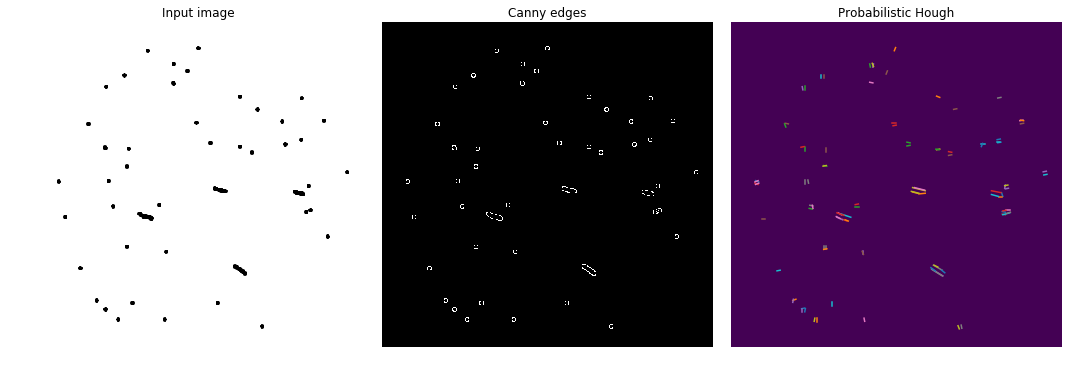

In [14]:
#Construct Image
im = Image.open("outliers.png") # open colour image
im = im.convert('L') # convert image to monochrome - this works
image=np.array(im)

#Get Canny Edges
edges = canny(image, 2, 1, 25)

#Probabilistic Hough Transform
lines = probabilistic_hough_line(edges, threshold=10, line_length=5, line_gap=3)

#Plot ------------------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()
#Input Image -----------------------------------------------------------------------------
ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
#Canny Edges -----------------------------------------------------------------------------
ax[1].imshow(edges, cmap=cm.gray)
ax[1].set_title('Canny edges')
#Probabilistic Hough Lines ---------------------------------------------------------------
ax[2].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

line_length = 5 is far too small, as the background objects are picked up.  However, the probabilistic hough transform currently works better than the straight-line version

#### line_length = 15

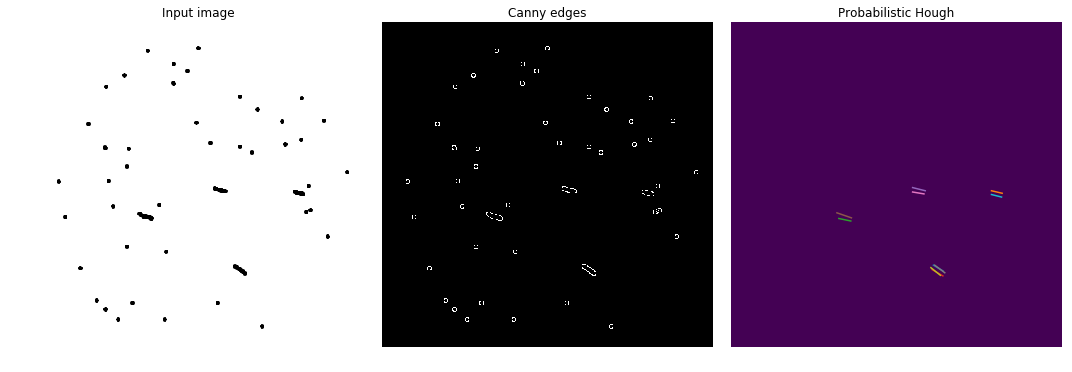

In [13]:
#Construct Image
im = Image.open("outliers.png") # open colour image
im = im.convert('L') # convert image to monochrome - this works
image=np.array(im)

#Get Canny Edges
edges = canny(image, 2, 1, 25)

#Probabilistic Hough Line
lines = probabilistic_hough_line(edges, threshold=10, line_length=15, line_gap=3)

#Plot ------------------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()
#Input Image -----------------------------------------------------------------------------
ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
#Canny Edges -----------------------------------------------------------------------------
ax[1].imshow(edges, cmap=cm.gray)
ax[1].set_title('Canny edges')
#Probabilistic Hough Lines ---------------------------------------------------------------
ax[2].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

line_length = 15 is much better, but you still get two lines per tracklet.  I thought skipping the canny edges step might help, but.......

#### no edges

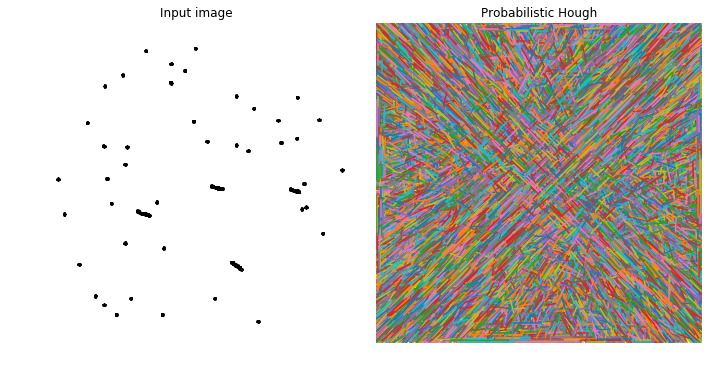

In [17]:
#Construct Image
im = Image.open("outliers.png") # open colour image
im = im.convert('L') # convert image to monochrome - this works
image=np.array(im)

#Probabilistic Hough Line
lines = probabilistic_hough_line(image, threshold=10, line_length=15,
                                 line_gap=3)

#Plot ------------------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax = axes.ravel()
#Input Image -----------------------------------------------------------------------------
ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
#Probabilistic Hough Lines ---------------------------------------------------------------
ax[1].imshow(image)
for line in lines:
    p0, p1 = line
    ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[1].set_xlim((0, image.shape[1]))
ax[1].set_ylim((image.shape[0], 0))
ax[1].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

Oh no.  Oh no no no.  This is the worst of them all.  It seems obvious at this point that both the probabilistic and straight-line hough transforms are detecting the white parts of an image and putting lines there.    

# III. Inverted colors

## i. Probabilistic Hough
#### no edges

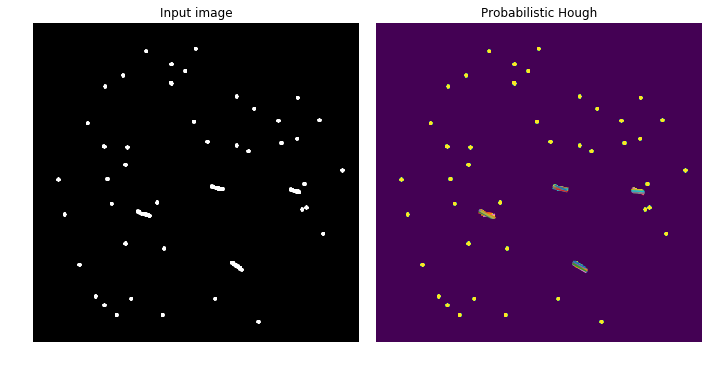

In [19]:
im = Image.open("outliers.png") # open colour image
im = im.convert('L') # convert image to monochrome - this works
inv = PIL.ImageOps.invert(im)
image=np.array(inv)

#Probabilistic Hough Line
lines = probabilistic_hough_line(image, threshold=10, line_length=15,
                                 line_gap=3)

#Plot ------------------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax = axes.ravel()
#Input Image -----------------------------------------------------------------------------
ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
#Probabilistic Hough Lines ---------------------------------------------------------------
ax[1].imshow(image)
for line in lines:
    p0, p1 = line
    ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[1].set_xlim((0, image.shape[1]))
ax[1].set_ylim((image.shape[0], 0))
ax[1].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

This doesn't work well at all.  The lines seem to get fit but because of the thickness of the points, multiple lines end up on each tracklet.  And I don't know what's going on with the background objects. 

## ii. Straight-line Hough

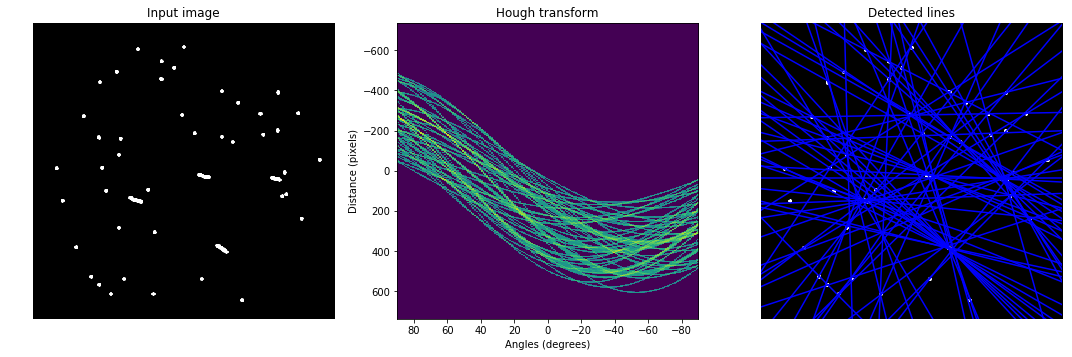

In [15]:
# Constructing image
im = Image.open("outliers.png") # open colour image
im = im.convert('L') # convert image to monochrome - this works
inv = PIL.ImageOps.invert(im)
image=np.array(inv)

# Classic straight-line Hough transform
h, theta, d = hough_line(image)

#Plot -----------------------------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()
#Input Image ----------------------------------------------------------------------------------------
ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()
#Hough Transform ------------------------------------------------------------------------------------
ax[1].imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
             aspect=.12/1)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
#Detected Lines -------------------------------------------------------------------------------------
ax[2].imshow(image, cmap=cm.gray)
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - image.shape[1] * np.cos(angle)) / np.sin(angle)
    ax[2].plot((0, image.shape[1]), (y0, y1), '-r',color='blue')
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.tight_layout()
plt.show()

It's not.....great.  This works a lot better than it does on the uninverted image because lines actually seem to intersect points.  The only problem is that they intersect a lot of the background stars/galaxies as well. Given that in Example 2, the image had a lot of background noise, I think there may be a way to get this to work.  It all has to do with the input image.  

# IV.  An attempt to create a better input image

### Smaller markers

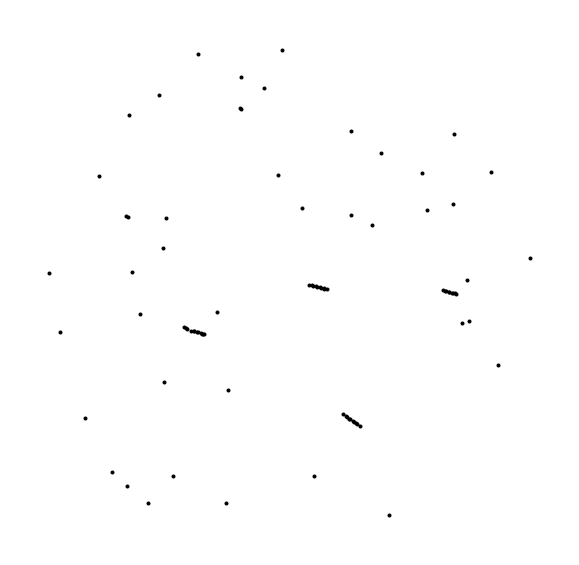

In [102]:
plt.figure(figsize=(10,10))
plt.scatter(dat_m[outliers]['ra'],dat_m[outliers]['dec'],marker='.',c="Black")
plt.ticklabel_format(useOffset=False)
plt.tick_params(left=False,bottom=False,labelleft=False, labelbottom=False)
plt.box(False)
plt.show()

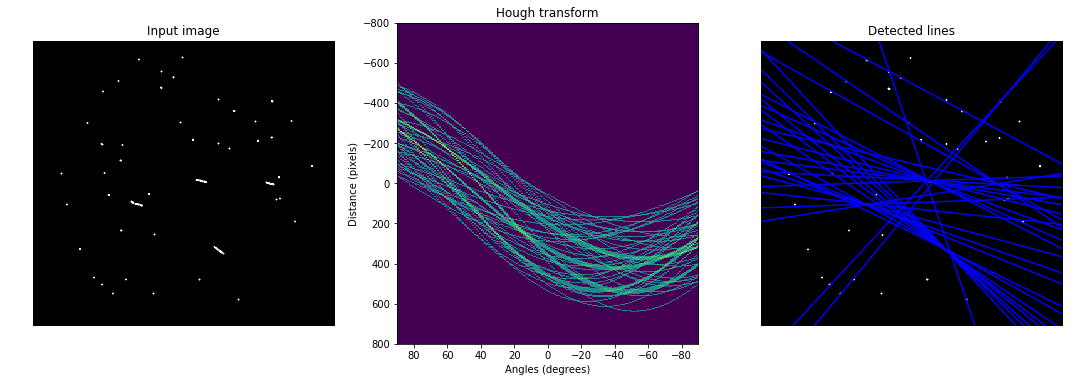

In [43]:
# Constructing image
im = Image.open("point_outliers.png") # open colour image
im = im.convert('L') # convert image to monochrome - this works
inv = PIL.ImageOps.invert(im)
image=np.array(inv)

# Classic straight-line Hough transform
h, theta, d = hough_line(image)

#Plot -----------------------------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()
#Input Image ----------------------------------------------------------------------------------------
ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()
#Hough Transform ------------------------------------------------------------------------------------
ax[1].imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
             aspect=.12/1)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
#Detected Lines -------------------------------------------------------------------------------------
ax[2].imshow(image, cmap=cm.gray)
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - image.shape[1] * np.cos(angle)) / np.sin(angle)
    ax[2].plot((0, image.shape[1]), (y0, y1), '-r',color='blue')
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.tight_layout()
plt.show()

Woah. That's better, but each tracklet still just has a bunch of lines traced through it.  

A slightly different image:

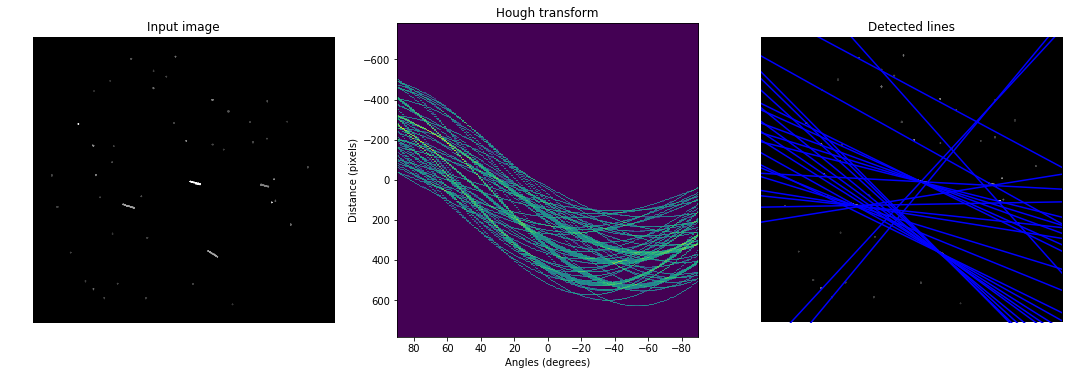

In [75]:
# Constructing image
im = Image.open("col_outliers.png") # open colour image
im = im.convert('L') # convert image to monochrome - this works
inv = PIL.ImageOps.invert(im)
image=np.array(inv)

# Classic straight-line Hough transform
h, theta, d = hough_line(image)

#Plot -----------------------------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()
#Input Image ----------------------------------------------------------------------------------------
ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()
#Hough Transform ------------------------------------------------------------------------------------
ax[1].imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
             aspect=.12/1)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
#Detected Lines -------------------------------------------------------------------------------------
ax[2].imshow(image, cmap=cm.gray)
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - image.shape[1] * np.cos(angle)) / np.sin(angle)
    ax[2].plot((0, image.shape[1]), (y0, y1), '-r',color='blue')
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.tight_layout()
plt.show()

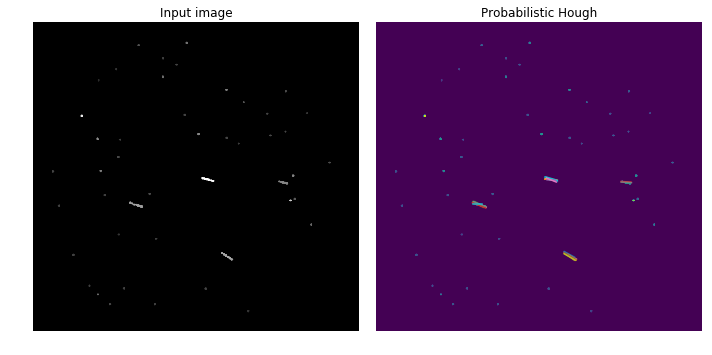

In [100]:
im = Image.open("col_outliers.png") # open colour image
im = im.convert('L') # convert image to monochrome - this works
inv = PIL.ImageOps.invert(im)
image=np.array(inv)

#Probabilistic Hough Line
lines = probabilistic_hough_line(image, threshold=10, line_length=15,
                                 line_gap=3)

#Plot ------------------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax = axes.ravel()
#Input Image -----------------------------------------------------------------------------
ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
#Probabilistic Hough Lines ---------------------------------------------------------------
ax[1].imshow(image)
for line in lines:
    p0, p1 = line
    ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[1].set_xlim((0, image.shape[1]))
ax[1].set_ylim((image.shape[0], 0))
ax[1].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

Clearly, further investigation is necessary.